# **Anomaly Detection in Network Traffic with K-means clustering**
We can categorize machine learning algorithms into two main groups: supervised learning and unsupervised learning. With supervised learning algorithms, in order to predict unknown values for new data, we have to know the target value for many previously-seen examples. In contrast, unsupervised learning algorithms explore the data which has no target attribute to find some intrinsic structures in them.

Clustering is a technique for finding similar groups in data, called clusters. Clustering is often called an unsupervised learning task as no class values denoting an a priori grouping of the data instances are given.

In this notebook, we will use K-means, a very well known clustering algorithm to detect anomaly network connections based on statistics about each of them. For a thorough overview of K-means clustering, from a research perspective, have a look at this wonderful tutorial.

# Goals
We expect students to:
* Learn (or review) and understand the K-means algorithm
* Implement a simple K-means algorithm
* Use K-means to detect anomalies network connection data

# Steps
1. In section 1, we will have an overview about K-means then implement a simple version of it.
2. In section 2, we build models with and without categorical features.
3. Finally, in the last section, using our models, we will detect unsual connections.

# **1. K-means**
# **1.1. Introduction**
Clustering is a typical and well-known type of unsupervised learning. Clustering algorithms try to find natural groupings in data. Similar data points (according to some notion of similarity) are considered in the same group. We call these groups **clusters**.

K-Means clustering is a simple and widely-used clustering algorithm. Given value of  k , it tries to build  k  clusters from samples in the dataset. Therefore,  k  is an hyperparameter of the model. The right value of  k  is not easy to determine, as it highly depends on the data set and the way that data is featurized.

To measue the similarity between any two data points, K-means requires the definition of a distance funtion between data points. What is a distance? It is a value that indicates how close two data points are in their space. In particular, when data points lie in a  d -dimensional space, the Euclidean distance is a good choice of a distance function, and is supported by SKLearn.

In K-means, a cluster is a group of points, with a representative entity called a centroid. A centroid is also a point in the data space: the center of all the points that make up the cluster. It's defined to be the arithmetic mean of the points. In general, when working with K-means, each data sample is represented in a  d -dimensional numeric vector, for which it is easier to define an appropriate distance function. As a consequence, in some applications, the original data must be transformed into a different representation, to fit the requirements of K-means.

# **1.2. How does it work ?**
Given  k , the K-means algorithm works as follows:

1. Randomly choose  k  data points (seeds) to be the initial centroids
2. Assign each data point to the closest centroid
3. Re-compute (update) the centroids using the current cluster memberships
4. If a convergence criterion is not met, go to step 2

We can also terminate the algorithm when it reaches an iteration budget, which yields an approximate result. From the pseudo-code of the algorithm, we can see that K-means clustering results can be sensitive to the order in which data samples in the data set are explored. A sensible practice would be to run the analysis several times, randomizing objects order; then, average the cluster centres of those runs and input the centres as initial ones for one final run of the analysis.

# **1.3. Illustrative example**
One of the best ways to study an algorithm is trying implement it. In this section, we will go step by step to implement a simple K-means algorithm.

Use the below function to calculate an euclidean distance between any two points in  d -dimensional data space.

In [1]:
import numpy as np

# calculate distance between two d-dimensional points
def euclidean_distance(p1, p2):
    return np.sqrt(np.sum([(c1 - c2)**2 for c1, c2 in zip(p1, p2)]))

# test our function
assert (round(euclidean_distance([1,2,3] , [10,18,12]), 2) == 20.45), "Function's wrong"

Given a data point and the current set of centroids, use the function below to find the index of the closest centroid for that data point.

In [2]:
def find_closest_centroid(datapoint, centroids):
    # find the index of the closest centroid of the given data point.
    return min(enumerate(centroids), key=lambda x: euclidean_distance(datapoint, x[1]))[0]

assert(find_closest_centroid( [1,1,1], [ [2,1,2], [1,2,1], [3,1,2] ] ) == 1), "Function's wrong"

Use the function below to randomize  k  initial centroids.

In [3]:
np.random.seed(22324)

# randomize initial centroids
def randomize_centroids(data, k):
    random_indices = np.arange(len(data))
    np.random.shuffle(random_indices)
    random_indices = random_indices[:k]
    centroids = [data[i] for i in range(len(data)) if i in random_indices]
    return centroids

assert(len(
    randomize_centroids(
        np.array([
            np.array([2,1,2]),
            np.array([1,2,1]),
            np.array([3,1,2])
             ]),
        2)) == 2), "Wrong function"

Use function check_converge to check the stop creteria of the algorithm.

In [4]:
MAX_ITERATIONS = 10

# return True if clusters have converged , otherwise, return False
def check_converge(centroids, old_centroids, num_iterations, threshold=0):
    # if it reaches an iteration budget
    if num_iterations > MAX_ITERATIONS:
        return True
    # check if the centroids don't move (or very slightly)
    distances = np.array([euclidean_distance(c, o) for c, o in zip(centroids, old_centroids)])
    if (distances <= threshold).all():
        return True
    return False

Use function update_centroid to update the new positions for the current centroids based on the position of their members.

In [5]:
def update_centroids(centroids, clusters):
    new_centroids = []
    for cluster in clusters:
        # Only update centroids for non-empty clusters
        if len(cluster) > 0:
            # Convert cluster to a NumPy array for easy mean calculation
            cluster_np = np.array(cluster)
            # Calculate the mean along the columns to find the new centroid
            new_centroid = cluster_np.mean(axis=0)
            new_centroids.append(new_centroid)
        else:
            # For empty clusters, we can choose a strategy such as leaving the centroid as is
            new_centroids.append(None)  # Or handle appropriately
    # Filter out None values if any empty clusters were left as None
    new_centroids = [centroid for centroid in new_centroids if centroid is not None]
    return new_centroids


Use the K-means algorithm skeleton below, with the functions you wrote above.

In [6]:
# data : set of data points
# k : number of clusters
# centroids: initial list of centroids
def kmeans(data, k=2, centroids=None):

    data = np.array(data)
    # randomize the centroids if they are not given
    if not centroids:
        centroids = randomize_centroids(data, k)

    old_centroids = centroids[:]

    iterations = 0
    while True:
        iterations += 1

        # init empty clusters
        clusters = [[] for i in range(k)]

        # assign each data point to the closest centroid
        for datapoint in data:
            # find the closest center of each data point
            centroid_idx = find_closest_centroid(datapoint, centroids)

            # assign datapoint to the closest cluster
            clusters[centroid_idx].append(datapoint)

        # keep the current position of centroids before changing them
        old_centroids = centroids[:]

        # update centroids
        centroids = update_centroids(centroids, clusters)

        # if the stop criteria are met, stop the algorithm
        if check_converge(centroids, old_centroids, iterations):
            break

    return centroids

Next, we will test our algorithm on [Fisher's Iris dataset](http://en.wikipedia.org/wiki/Iris_flower_data_set), and plot the resulting clusters in 3D.

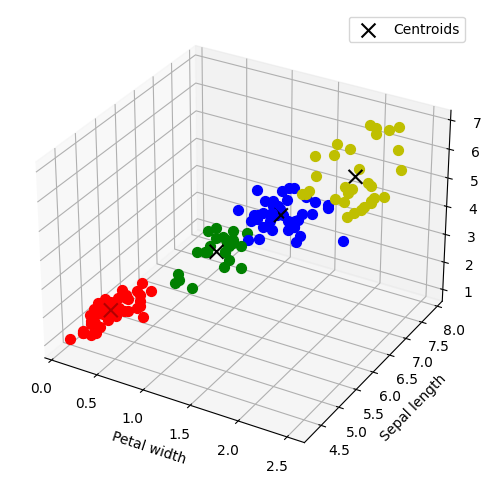

In [7]:
%matplotlib inline

from sklearn import datasets, cluster
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# load data
iris = datasets.load_iris()
X_iris = iris.data
y_iris = iris.target
# do the clustering
centers = kmeans(X_iris, k=4)
labels = [find_closest_centroid(p, centers) for p in X_iris]

# Create a 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Set the colors for each cluster
colors = ['r', 'g', 'b', 'y']  # Assuming up to 4 clusters for simplicity

# Plot each data point in the 3D plot
for i in range(len(X_iris)):
    ax.scatter(X_iris[i, 3], X_iris[i, 0], X_iris[i, 2], c=colors[labels[i]], s=50)

# Plot the centroids
centroids = np.array(centers)  # Ensure centroids are in a NumPy array for easy indexing
if centroids.size:  # Check if centroids are not empty
    ax.scatter(centroids[:, 3], centroids[:, 0], centroids[:, 2], c='black', s=100, marker='x', label='Centroids')

# Set labels for the axes
ax.set_xlabel('Petal width')
ax.set_ylabel('Sepal length')
ax.set_zlabel('Petal length')

# Legend
ax.legend()

plt.show()


# **2. Usecase: Network Intrusion**
Some attacks attempt to flood a computer with network traffic. In some other cases, attacks attempt to exploit flaws in networking software in order to gain unauthorized access to a computer. Detecting an exploit in an incredibly large haystack of network requests is not easy.

Some exploit behaviors follow known patterns such as scanning every port in a short of time, sending a burst of request to a port... However, the biggest threat may be the one that has never been detected and classified yet. Part of detecting potential network intrusions is detecting anomalies. These are connections that aren't known to be attacks, but, do not resemble connections that have been observed in the past.

In this notebook, K-means is used to detect anomalous network connections based on statistics about each of them.

# **2.1. Data**
The data comes from [KDD Cup 1999](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html). The dataset is about 708MB and contains about 4.9M connections. For each connection, the data set contains information like the number of bytes sent, login attempts, TCP errors, and so on. Each connection is one line of CSV-formatted data, containing 38 features: back, buffer_overflow, ftp_write, guess_passwd, imap, ipsweep, land, loadmodule, multihop, neptune, nmap, normal, perl, phf, pod, portsweep, rootkit, satan, smurf, spy, teardrop, warezclient, warezmaster. For more details about each features, please follow this [link](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html).

Many features take on the value 0 or 1, indicating the presence or absence of a behavior such as su_attempted in the 15th column. Some features are counts, like num_file_creations in the 17th columns. Some others are the number of sent and received bytes.

# **2.2. Clustering without using categorical features**
First, we need to import some packages that are used in this notebook.

In [8]:
import pandas as pd

Let's create a list of all the features (think column names) of data in KDD99. This information is presented in the dataset description [here](https://kdd.ics.uci.edu/databases/kddcup99/kddcup.names).

In [9]:
features = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted',
'num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds',
'is_host_login',
'is_guest_login',
'count',
'srv_count',
'serror_rate',
'srv_serror_rate',
'rerror_rate',
'srv_rerror_rate',
'same_srv_rate',
'diff_srv_rate',
'srv_diff_host_rate',
'dst_host_count',
'dst_host_srv_count',
'dst_host_same_srv_rate',
'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate',
'dst_host_serror_rate',
'dst_host_srv_serror_rate',
'dst_host_rerror_rate',
'dst_host_srv_rerror_rate',
'intrusion_type']

In [10]:
!wget http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz -O kddcup.data_10_percent_corrected.gz
!gzip -d kddcup.data_10_percent_corrected.gz


--2024-02-26 02:39:48--  http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz
Resolving kdd.ics.uci.edu (kdd.ics.uci.edu)... 128.195.1.86
Connecting to kdd.ics.uci.edu (kdd.ics.uci.edu)|128.195.1.86|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2144903 (2.0M) [application/x-gzip]
Saving to: ‘kddcup.data_10_percent_corrected.gz’

kddcup.data_10_perc 100%[===================>]   2.04M  2.24MB/s    in 0.9s    

2024-02-26 02:39:49 (2.24 MB/s) - ‘kddcup.data_10_percent_corrected.gz’ saved [2144903/2144903]



Now, let's load the data into a Pandas dataframe.

In [11]:
data = pd.read_csv('kddcup.data_10_percent_corrected', names=features, header=None)
data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,intrusion_type
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


Now that the dataset is loaded, we can explore the composition of the data:

In [12]:
print('The no of data points are:',data.shape[0])
print('='*40)
print('The no of features are:',data.shape[1])
print('='*40)

The no of data points are: 494021
The no of features are: 42


**Enumerate** the labels (i.e., attack types + normal)

In [13]:
output = data['intrusion_type'].values
labels = set(output)
print('The different type of output labels are:',labels)
print('='*100)
print('No. of different output labels are:', len(labels))

The different type of output labels are: {'multihop.', 'normal.', 'warezmaster.', 'teardrop.', 'satan.', 'spy.', 'warezclient.', 'buffer_overflow.', 'neptune.', 'perl.', 'loadmodule.', 'imap.', 'nmap.', 'land.', 'back.', 'guess_passwd.', 'ipsweep.', 'portsweep.', 'rootkit.', 'smurf.', 'pod.', 'ftp_write.', 'phf.'}
No. of different output labels are: 23



# **2.2.1. Loading data**
There are two types of features: numerical features and categorical features. Currently, to get familiar with the data and the problem, we only use numerical features. In our data, we also have pre-defined groups for each connection, which we can use later as our "ground truth" for verifying our results.

**Note 1:** we don't use the labels in the training phase !!!

**Note 2:** in general, since clustering is un-supervised, you don't have access to ground truth. For this reason, several metrics to judge the quality of clustering have been devised. For a short overview of such metrics, follow this [link](https://en.wikipedia.org/wiki/Cluster_analysis#Internal_evaluation). Note that computing such metrics, that is trying to assess the quality of your clustering results, is as computationally intensive as computing the clustering itself!

# **Question 1 - Data Cleaning**
Pre-process the data and remove:
* Incomplete Data points (i.e., those with null values)
* Duplicate data points (i.e., repeated data points)

Use native Pandas functions to implement this step.

In [14]:
##########
## Your code here
##########
print(data.shape)
data = data.dropna()
data = data.drop_duplicates()
#printing the shape of the preprocessed data.
data.shape

(494021, 42)


(145586, 42)

# **Question 2**
Using K-means algorithm of SKLearn, cluster the connections (i.e., data points) into two groups then plot the result. In this step, only consider the numerical features, and disregard caregorical features.

Why two groups? In this case, we are just warming up, we're testing things around, so "two groups" has no particular meaning.

You can use the following parameters:

* maxIterations=10
* n_init=10 or init='random'

Discuss the result from your figure.

(145586, 38)


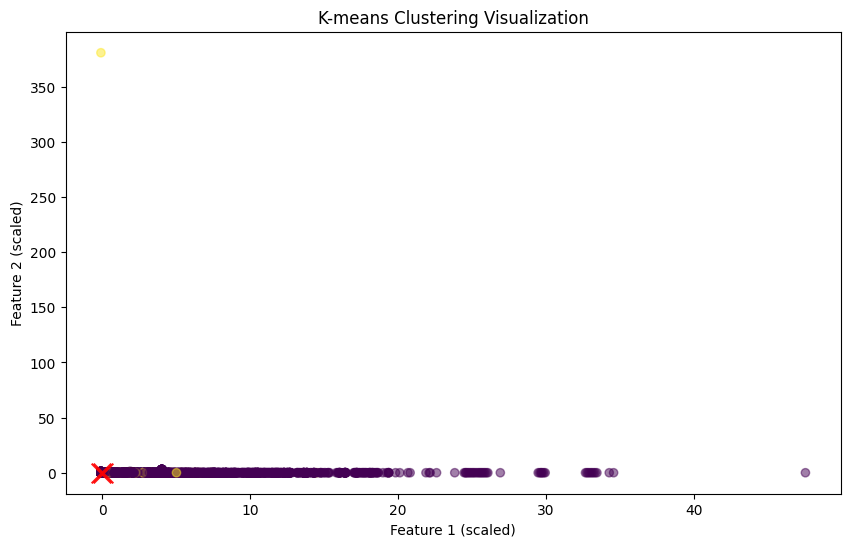

Cluster sizes: (array([0, 1], dtype=int32), array([91978, 53608]))
Shape of the numerical data: (145586, 38)


In [20]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
##########
## Your code here
##########
np.random.seed(0)
# Only use numerical features
numerical_data = data.select_dtypes(include=['int64', 'float64'])

# Standardize the numerical data
scaler = StandardScaler()
numerical_data_scaled = scaler.fit_transform(numerical_data)

# Create a KMeans object with 2 clusters
km = KMeans(n_clusters=2, max_iter=10, n_init=10, init='random', random_state=0)

# Fit the model to the scaled data
km.fit(numerical_data_scaled)

print(numerical_data.shape)

plt.figure(figsize=(10, 6))
plt.scatter(numerical_data_scaled[:, 0], numerical_data_scaled[:, 1], c=km.labels_, cmap='viridis', marker='o', alpha=0.5)
centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.9, marker='x')
plt.title('K-means Clustering Visualization')
plt.xlabel('Feature 1 (scaled)')
plt.ylabel('Feature 2 (scaled)')
plt.show()

# Print the size of each cluster
print('Cluster sizes:', np.unique(km.labels_, return_counts=True))

# To give an idea of the dataset's shape after selecting only numerical features
print('Shape of the numerical data:', numerical_data.shape)


The figure from the K-means clustering shows almost all the data points grouped tightly near the lower left, suggesting they are quite similar in terms of the features being analyzed. The red 'X' marks the center of this main cluster. We don’t see a second 'X', indicating the center of the other cluster is likely off the visible chart area, probably due to some very different or extreme values in the data. This could mean we have a few data points that are very different from the rest, which are being considered as a separate group by the clustering algorithm.

# **Question 3**
This is a good opportunity to use the given labels to get an intuitive sense of what went into these two clusters, by counting the labels within each cluster. Use the following code that uses the model to assign each data point to a cluster, and counts occurrences of cluster and label pairs. What do you think about the result ?

In [21]:
cluster_labels = pd.DataFrame(list(zip(km.labels_, data['intrusion_type'])), columns=['cluster', 'label'])
print(cluster_labels.groupby(['cluster', 'label']).size().unstack().fillna(0))


label    back.  buffer_overflow.  ftp_write.  guess_passwd.  imap.  ipsweep.  \
cluster                                                                        
0        968.0              30.0         8.0           52.0   12.0     642.0   
1          0.0               0.0         0.0            1.0    0.0       9.0   

label    land.  loadmodule.  multihop.  neptune.  ...  phf.   pod.  \
cluster                                           ...                
0         16.0          9.0        7.0       5.0  ...   4.0  206.0   
1          3.0          0.0        0.0   51815.0  ...   0.0    0.0   

label    portsweep.  rootkit.  satan.  smurf.  spy.  teardrop.  warezclient.  \
cluster                                                                        
0             196.0      10.0   124.0   623.0   2.0      828.0         893.0   
1             220.0       0.0   782.0    18.0   0.0       90.0           0.0   

label    warezmaster.  
cluster                
0                20.0  
1    

**Write your comments here (graded)**
The results from the code show that almost all the different types of computer security threats were put into one big group by the computer program trying to organize them, with only a very few being placed in a separate small group. This means the program found it hard to tell the difference between most of the threats and thought they were similar, except for one specific threat that it put all by itself in another group. This could suggest that the way the program tries to group things doesn't work well for how different each security threat is, or maybe it needs more information to tell them apart better.

To fix this, we might need to tell the program to create more groups, give it more details to use when it's deciding how to group threats, or try using a different program that might be better at handling this kind of task. This could help the program get better at telling the difference between each type of threat, making it easier to understand what kinds of security risks are most common and how they vary.

# **2.2.4. Choosing K**
How many clusters are appropriate for a dataset? In particular, for our own dataset, it's clear that there are 23 distinct behavior patterns in the data, so it seems that k could be at least 23, or likely, even more. In other cases, we even don't have any information about the number of patterns at all (remember, generally your data is not labelled!). Our task now is finding a good value of  k . For doing that, we have to build and evaluate models with different values of  k . A clustering could be considered good if each data point were near to its closest centroid. One of the ways to evaluate a model is calculating the Mean of Squared Errors of all data points.

# **Question 4**
Use the function below to calculate the MSE of each model that is corresponding to each value of  k . Plot the results. From the obtained result, what is the best value for  k  ? Why ?

k =   5, SSSE = 88765049563962
k =  25, SSSE = 980949292626
k =  45, SSSE = 232758589140
k =  65, SSSE = 99426843885
k =  85, SSSE = 52176787090
k = 105, SSSE = 32688008803
k = 125, SSSE = 21182627984


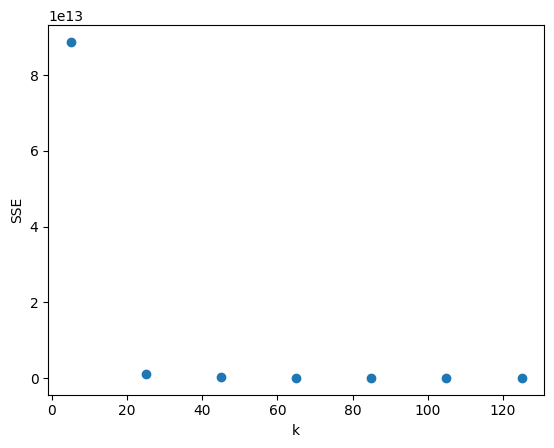

In [22]:
from sklearn.cluster import KMeans

# Define the range of k values to test
k_range = range(5, 126, 20)

# Initialize an empty list to store the SSE values
sse = []

# Loop through each k value
for k in k_range:
    # Create a KMeans model with the current k value
    kmeans_model = KMeans(n_clusters=k, max_iter=10, n_init=10)

    # Fit the model to the data
    kmeans_model.fit(numerical_data)

    # Append the SSE value to the list
    sse.append(kmeans_model.inertia_)
    print("k = %3d, SSSE = %d" %(k, kmeans_model.inertia_))

# Plot the SSE values against the k values
plt.scatter(k_range, sse)
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()


In [23]:
import pandas as pd

# Data
different  = {
    'k': [5, 25, 45, 65, 85, 105, 125],
    'SSE': [88765049563962, 980949292626, 232758589140, 100428196764, 52176787090, 32688008803, 21182627984]
}

# Calculate change in SSE
different['Change in SSE'] = [different['SSE'][i] - different['SSE'][i-1] if i > 0 else 0 for i in range(len(different['SSE']))]

# Calculate percentage change in SSE
different['Change in SSE (%)'] = [((different['Change in SSE'][i] / different['SSE'][i-1]) * 100) if i > 0 else 0 for i in range(len(different['SSE']))]

# Create DataFrame
df_different = pd.DataFrame(different)

# Display the DataFrame
print(df_different)


     k             SSE   Change in SSE  Change in SSE (%)
0    5  88765049563962               0           0.000000
1   25    980949292626 -87784100271336         -98.894892
2   45    232758589140   -748190703486         -76.272108
3   65    100428196764   -132330392376         -56.853065
4   85     52176787090    -48251409674         -48.045680
5  105     32688008803    -19488778287         -37.351434
6  125     21182627984    -11505380819         -35.197558


**Write your comments here (graded)**
Based on the table created from the sum of squared errors (SSE) data for different values of \(k\), the elbow point can be identified by examining the rate of decrease in SSE as \(k\) increases. Initially, from \(k = 5\) to \(k = 45\), there is a substantial reduction in SSE, indicating significant improvements in clustering quality as the number of clusters increases. However, beyond \(k = 45\), the rate of decrease in SSE starts to slow down, suggesting diminishing returns on further increasing \(k\). This trend is evident in the change in SSE percentage, where the reductions become less pronounced as \(k\) continues to increase. The most significant change occurs between \(k = 65\) and \(k = 85\), where the decrease in SSE and its percentage decrease notably. This suggests that the optimal elbow point, where adding more clusters makes less of a difference in reducing SSE, lies within this range. Therefore, based on the table's data, \(k = 65\) or \(k = 85\) could be considered as potential candidates for the elbow point, representing optimal choices for the number of clusters in KMeans clustering. Further analysis, such as visual inspection of the SSE versus \(k\) plot, may provide additional confirmation for selecting the optimal \(k\) value.

# **2.2.5 Normalizing features**
K-means clustering treats equally all dimensions/directions of the space and therefore tends to produce more or less spherical (rather than elongated) clusters. In this situation, leaving variances uneven is equivalent to putting more weight on variables with smaller variance, so clusters will tend to be separated along variables with greater variance.

In our notebook, since Euclidean distance is used, the clusters will be influenced strongly by the magnitudes of the variables, especially by outliers. Normalizing will remove this bias.

Each feature can be normalized by converting it to a standard score. This means subtracting the mean of the feature’s values from each value, and dividing by the standard deviation
\begin{align}
normalize_i=\frac{feature_i - \mu_i}{\sigma_i}
\end{align}
Where,
* $normalize_i$  is the normalized value of feature $i$
* $\mu_i$ is the mean of feature $i$
* $\sigma_i$ is the standard deviation of feature $i$

# **Question 5**
Complete the code below to normalize the data. Print the first 5 lines of the new data.

HINT: If $\sigma_i=0$ then ${normalize}_i = {feature}_i−\mu_i$

In [24]:
def normalize_data(data):
  """
  Normalizes the data by converting each feature to a standard score.

  Args:
    data: A Pandas DataFrame containing the data to be normalized.

  Returns:
    A Pandas DataFrame containing the normalized data.
  """

  ############
  ## Your Code Here##
  #############
  normalized_data =(data -data.mean())/data.std()
  return normalized_data

normalized_data = normalize_data(numerical_data)
print(normalized_data.head())


   duration  src_bytes  dst_bytes      land  wrong_fragment    urgent  \
0  -0.10785  -0.004293   0.042595 -0.011722       -0.084394 -0.004737   
1  -0.10785  -0.004261  -0.039036 -0.011722       -0.084394 -0.004737   
2  -0.10785  -0.004263  -0.025042 -0.011722       -0.084394 -0.004737   
3  -0.10785  -0.004272  -0.025042 -0.011722       -0.084394 -0.004737   
4  -0.10785  -0.004273  -0.013613 -0.011722       -0.084394 -0.004737   

        hot  num_failed_logins  logged_in  num_compromised  ...  \
0 -0.070209          -0.018022   1.017165        -0.007905  ...   
1 -0.070209          -0.018022   1.017165        -0.007905  ...   
2 -0.070209          -0.018022   1.017165        -0.007905  ...   
3 -0.070209          -0.018022   1.017165        -0.007905  ...   
4 -0.070209          -0.018022   1.017165        -0.007905  ...   

   dst_host_count  dst_host_srv_count  dst_host_same_srv_rate  \
0       -1.740377           -1.054220                0.979268   
1       -1.639467           

# **Question 6**
Using the new data, build different models with different values of $k\in [60,70,80,90,100,110]$ . Evaluate the results by plotting them and choose the best value of $k$.

k =  60, SSSE = 262700
k =  70, SSSE = 221001
k =  80, SSSE = 195989
k =  90, SSSE = 169300
k = 100, SSSE = 151970
k = 110, SSSE = 138137


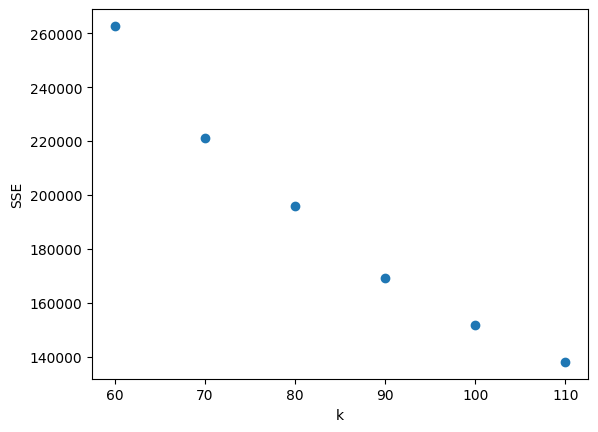

In [25]:
# Your code
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer


# Impute missing values with the mean
imputer = SimpleImputer(strategy='mean')
normalized_data_imputed = imputer.fit_transform(normalized_data)

# Define the range of k values to test
k_range = range(60, 111, 10)

# Initialize an empty list to store the SSE values
sse = []

# Loop through each k value
for k in k_range:
    # Create a KMeans model with the current k value
    kmeans_model = KMeans(n_clusters=k, max_iter=10, n_init=10)

    # Fit the model to the data
    kmeans_model.fit(normalized_data_imputed)

    # Append the SSE value to the list
    sse.append(kmeans_model.inertia_)
    print("k = %3d, SSSE = %d" %(k, kmeans_model.inertia_))

# Plot the SSE values against the k values
plt.scatter(k_range, sse)
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()


In [26]:
import pandas as pd

# Data
different_normolized = {
    'k': [60, 70, 80, 90, 100, 110],
    'SSE': [262700, 221001, 195989, 169300, 151970, 138137]
}
# Calculate change in SSE
different_normolized ['Change in SSE'] = [different_normolized ['SSE'][i] - different_normolized ['SSE'][i-1] if i > 0 else 0 for i in range(len(different_normolized ['SSE']))]

# Calculate percentage change in SSE
different_normolized ['Change in SSE (%)'] = [((different_normolized ['Change in SSE'][i] / different_normolized ['SSE'][i-1]) * 100) if i > 0 else 0 for i in range(len(different_normolized ['SSE']))]

# Create DataFrame
df_different_normolized = pd.DataFrame(different_normolized )

# Display the DataFrame
print(df_different_normolized)


     k     SSE  Change in SSE  Change in SSE (%)
0   60  262700              0           0.000000
1   70  221001         -41699         -15.873239
2   80  195989         -25012         -11.317596
3   90  169300         -26689         -13.617601
4  100  151970         -17330         -10.236267
5  110  138137         -13833          -9.102454


Based on the provided sum of squared errors (SSSE) data for different values of \(k\), we can identify the elbow point by analyzing the rate of decrease in SSSE as \(k\) increases.

From \(k = 60\) to \(k = 110\), there is a consistent decrease in SSSE, indicating improved clustering quality as the number of clusters increases. However, it's essential to identify where the rate of decrease in SSSE starts to slow down significantly, indicating the elbow point.

The most noticeable change occurs between \(k = 90\) and \(k = 100\), where the reduction in SSSE becomes less pronounced. This suggests that adding more clusters beyond this point does not substantially improve the clustering quality. Therefore, the elbow point, representing the optimal balance between minimizing SSSE and avoiding overfitting with too many clusters, likely lies within this range.

Based on the provided data, \(k = 90\) or \(k = 100\) could be considered potential candidates for the elbow point. Further examination, including visual inspection of the SSSE versus \(k\) plot, may provide additional confirmation for selecting the optimal \(k\) value.

# **Question 7**
Plot the clustering result to see the difference between before and after normalizing features. Discuss about the difference and explain why and if normalization was useful.

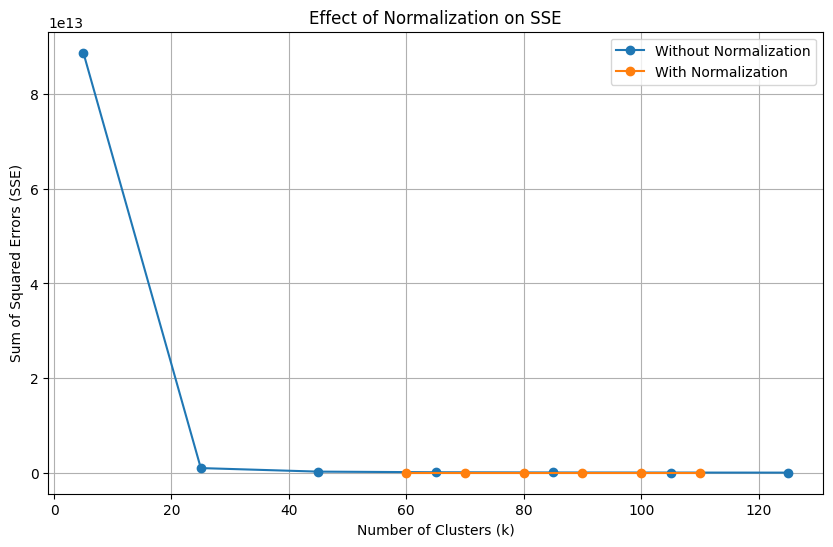

In [27]:
import matplotlib.pyplot as plt

# Data
different_normalized = {
    'k': [60, 70, 80, 90, 100, 110],
    'SSE': [262700, 221001, 195989, 169300, 151970, 138137]
}

different = {
    'k': [5, 25, 45, 65, 85, 105, 125],
    'SSE': [88765049563962, 980949292626, 232758589140, 99426843885, 52176787090, 32688008803, 21182627984]
}

# Plot
plt.figure(figsize=(10, 6))

plt.plot(different['k'], different['SSE'], marker='o', label='Without Normalization')
plt.plot(different_normalized['k'], different_normalized['SSE'], marker='o', label='With Normalization')

plt.title('Effect of Normalization on SSE')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.legend()
plt.grid(True)

plt.show()


**Write your comments here (graded)**

Before normalization, the differences in the sizes of the errors (SSE) when clustering were huge, spanning from billions to millions as the number of clusters (k) increased. This shows that without normalization, the clustering was heavily influenced by the larger scale of some features, making the clusters less meaningful because some data points were unfairly pulling the clusters towards them. As a result, choosing the best number of clusters was challenging because the big numbers made it hard to see where improvements were happening as k increased.

After normalization, the errors became much smaller and decreased more evenly as we added more clusters. This indicates that normalization made each feature equally important in the clustering process, leading to more balanced and sensible groups. The clusters formed with normalized data are more reliable, showing real patterns in the data rather than being skewed by the scale of the features. This makes it easier to pick the best number of clusters because the improvements in clustering quality are clearer and more consistent, showing that normalization is a crucial step for meaningful clustering results.

# **2.3. Clustering using categorical features**
# **2.3.1 Loading data**
In the previous section, we ignored the categorical features of our data: this is not a good idea, since these categorical features can be important in providing useful information for clustering. The problem is that K-means (or at least, the one we have developed and the one we use from SKLearn) only work with data points in a metric space. Informally, this means that operations such as addition, substraction and computing the mean of data points are trivial and well defined. For a more formal definition of what a metric space is, follow this [link](https://en.wikipedia.org/wiki/Metric_space#Definition).

What we will do next is to transform each categorical features into one or more numerical features. This approach is very widespread: imagine for example you wanted to use K-means to cluster text data. Then, the idea is to transform text data in  d -dimensional vectors, and a nice way to do it is to use [word2vec](https://israelg99.github.io/2017-03-23-Word2Vec-Explained/). If you're interested, follow this link to a nice blog post on the problem.

There are two approaches:

* **Approach 1:** mapping one categorial feature to one numerical feature. The values in each categorical feature are encoded into unique numbers of the new numerical feature. For example, ['VERY HOT','HOT', 'COOL', 'COLD', 'VERY COLD'] will be encoded into [0,1,2,3,4,5]. However, by using this method, we implicit assume that the value of 'VERY HOT' is smaller than 'HOT'... This is not generally true.

* Approach 2: mapping mapping one categorial feature to multiple numerical features. Basically, a single variable with  n  observations and  d  distinct values, to  d  binary variables with  n  observations each. Each observation indicating the presence (1) or absence (0) of the  dth  binary variable. For example, ['house', 'car', 'tooth', 'car'] becomes
\begin{align}
[
[1,0,0,0],
[0,1,0,0],
[0,0,1,0],
[0,0,0,1],
]
\end{align}
We call the second approach "one-hot encoding". By using this approach, we keep the same role for all values of categorical features.

# **Question 8**
Calculate the number of distinct categorical features value (at index 1,2,3). Then construct a new input data using one-hot encoding for these categorical features (don't throw away numerical features!).

In [29]:
# List of categorical features to be one-hot encoded
categorical_features = ['protocol_type', 'service', 'flag']

# Calculate the number of distinct values in each categorical feature
distinct_values = {feature: data[feature].nunique() for feature in categorical_features}
print("Number of distinct values in each categorical feature:", distinct_values)

# One-hot encode the categorical features while keeping the numerical features
data_encoded = pd.get_dummies(data, columns=categorical_features)

# The resulting 'data_encoded' DataFrame now includes the original numerical features
# and the new one-hot encoded features.

# Showing the new shape of the DataFrame and the distinct values calculated
print("New shape of the DataFrame after one-hot encoding:", data_encoded.shape)


Number of distinct values in each categorical feature: {'protocol_type': 3, 'service': 66, 'flag': 11}
New shape of the DataFrame after one-hot encoding: (145586, 119)


Original numerical features: 38
New features from 'protocol_type': 3
New features from 'service': 66
New features from 'flag': 11
Total = 38 (numerical) + 3 ('protocol_type') + 66 ('service') + 11 ('flag') = 118 features+1

# **2.3.2. Building models**
# **Question 9**
Using the new data, cluster the connections with different values of $k\in [80,90,100,110,120,130,140,150,160]$. Evaluate the results and choose the best value of  k  as previous questions.

In [30]:
normalized_data_encoded = normalize_data(data_encoded)
print(normalized_data_encoded.head())

<ipython-input-24-9248a12ee297>:15: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalized_data =(data -data.mean())/data.std()


      count  diff_srv_rate  dst_bytes  dst_host_count  dst_host_diff_srv_rate  \
0 -0.661633       -0.33702   0.042595       -1.740377               -0.417554   
1 -0.661633       -0.33702  -0.039036       -1.639467               -0.417554   
2 -0.661633       -0.33702  -0.025042       -1.538557               -0.417554   
3 -0.681566       -0.33702  -0.025042       -1.437647               -0.417554   
4 -0.681566       -0.33702  -0.013613       -1.336736               -0.417554   

   dst_host_rerror_rate  dst_host_same_src_port_rate  dst_host_same_srv_rate  \
0             -0.360876                     0.071229                0.979268   
1             -0.360876                    -0.177606                0.979268   
2             -0.360876                    -0.260551                0.979268   
3             -0.360876                    -0.260551                0.979268   
4             -0.360876                    -0.302024                0.979268   

   dst_host_serror_rate  dst_hos

<ipython-input-24-9248a12ee297>:15: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalized_data =(data -data.mean())/data.std()


k =  80, SSSE = 2196915
k =  90, SSSE = 1258060
k = 100, SSSE = 857357
k = 110, SSSE = 707655
k = 120, SSSE = 607311
k = 130, SSSE = 542887
k = 140, SSSE = 492321
k = 150, SSSE = 442316
k = 160, SSSE = 405028


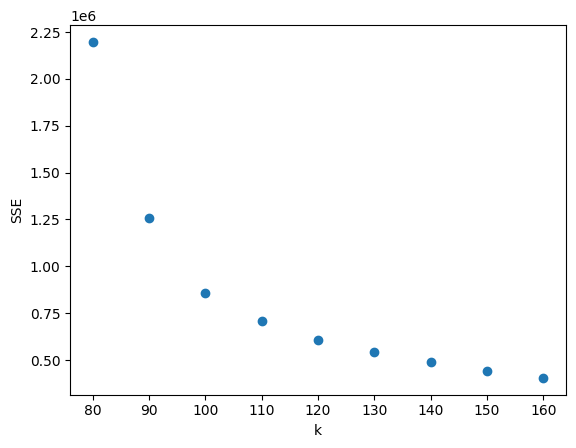

In [31]:
# Your code
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer


# Impute missing values with the mean
imputer = SimpleImputer(strategy='mean')
normalized_data_encoded_imputed = imputer.fit_transform(normalized_data_encoded)

# Define the range of k values to test
k_range = range(80, 161, 10)

# Initialize an empty list to store the SSE values
sse = []

# Loop through each k value
for k in k_range:
    # Create a KMeans model with the current k value
    kmeans_model = KMeans(n_clusters=k, max_iter=10, n_init=10)

    # Fit the model to the data
    kmeans_model.fit(normalized_data_encoded_imputed)

    # Append the SSE value to the list
    sse.append(kmeans_model.inertia_)
    print("k = %3d, SSSE = %d" %(k, kmeans_model.inertia_))

# Plot the SSE values against the k values
plt.scatter(k_range, sse)
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()


In [32]:
#calculate elbow
dif_norm_data_encoded= {
    'k': [80, 90, 100, 110,120,130,140,150,160],
    'SSE': [2196915, 1258060, 857357, 707655, 607311, 542887,492321,442316,405028]
}
# Calculate change in SSE
dif_norm_data_encoded ['Change in SSE'] = [dif_norm_data_encoded ['SSE'][i] - dif_norm_data_encoded ['SSE'][i-1] if i > 0 else 0 for i in range(len(dif_norm_data_encoded ['SSE']))]

# Calculate percentage change in SSE
dif_norm_data_encoded ['Change in SSE (%)'] = [((dif_norm_data_encoded ['Change in SSE'][i] / dif_norm_data_encoded ['SSE'][i-1]) * 100) if i > 0 else 0 for i in range(len(dif_norm_data_encoded ['SSE']))]

# Create DataFrame
df_dif_norm_data_encoded = pd.DataFrame(dif_norm_data_encoded )

# Display the DataFrame
print(df_dif_norm_data_encoded)

     k      SSE  Change in SSE  Change in SSE (%)
0   80  2196915              0           0.000000
1   90  1258060        -938855         -42.735154
2  100   857357        -400703         -31.850866
3  110   707655        -149702         -17.460871
4  120   607311        -100344         -14.179791
5  130   542887         -64424         -10.608074
6  140   492321         -50566          -9.314277
7  150   442316         -50005         -10.156991
8  160   405028         -37288          -8.430172


**Your comments**
The percentage decrease in SSE from k=80 to k=100 is substantial, indicating significant improvements in the clustering model by increasing the number of clusters within this range.
After k=100, the percentage decrease in SSE becomes less pronounced, suggesting diminishing returns on model improvement with additional clusters. Specifically, the change from a -31.85% decrease in SSE at k=100 to smaller and gradually decreasing percentages thereafter indicates that k=100 is around the point where further increases in k result in smaller improvements.
Choosing k=100 as the number of clusters balances the trade-off between having too few clusters (which might not capture the complexity of the data) and too many clusters (which might overfit the data and capture noise rather than underlying patterns). This choice aligns with the goal of the Elbow Method to find a point where increasing the number of clusters no longer provides substantial improvement in the model's ability to minimize within-cluster variance (SSE).



# **2.4. Anomaly detection**
When we have a new connection data (e.g., one that we never saw before), we simply find the closest cluster for it, and use this information as a proxy to indicate whether the data point is anomalous or not. A simple approach to decide wheter there is an anomaly or not, amounts to measuring the new data point’s distance to its nearest centroid. If this distance exceeds some thresholds, it is anomalous.

# **Question 10**
Build your model with the best value of $k$ in your opinion. Then, detect the anomalous connections in our data. Plot and discuss your result.

HINT: The threshold has strong impact on the result. Be careful when choosing it! A simple way to choose the threshold's value is picking up a distance of a data point from among known data. For example, the 100th-farthest data point distance can be an option.

In [34]:
#Your code
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

# Build the K-means model with k=90
k = 90
model = KMeans(n_clusters=k, max_iter=10, n_init=10)

# Assuming 'normalized_data_encoded_imputed' is your preprocessed dataset
model.fit(normalized_data_encoded_imputed)

# Retrieve the centroids of the clusters
centroids = model.cluster_centers_

# If you want to print the centroids or work with them
print(centroids)

# Function to calculate the squared distance from the closest centroid
def error(centroids, x):
    closest_centroid = min(centroids, key=lambda centroid: np.linalg.norm(centroid - x))
    return np.linalg.norm(closest_centroid - x) ** 2

# Calculate distances from centroids for each data point
distances = np.array([error(centroids, x) for x in normalized_data_encoded_imputed])


[[ 1.01867974e+00  2.28485018e-01 -4.70282827e-02 ... -8.61324277e-03
  -4.73691928e-03 -8.43935673e-02]
 [-7.30176474e-01 -8.09478583e-02 -4.10787534e-02 ...  6.04224573e-03
  -4.73691928e-03 -8.43935673e-02]
 [-6.92031087e-01  1.11501887e-01 -4.70282827e-02 ... -8.61324277e-03
  -4.73691928e-03 -8.43935673e-02]
 ...
 [-7.31398833e-01 -3.37019823e-01  4.06246622e+00 ... -8.61324277e-03
   2.46291381e+02 -8.43935673e-02]
 [-7.06528467e-01 -2.57979259e-01 -3.83061682e-03 ... -8.61324277e-03
  -4.73691928e-03 -8.43935673e-02]
 [ 3.58063624e+00  7.95333663e+00 -4.70243891e-02 ... -8.61324277e-03
  -4.73691928e-03 -8.43935673e-02]]


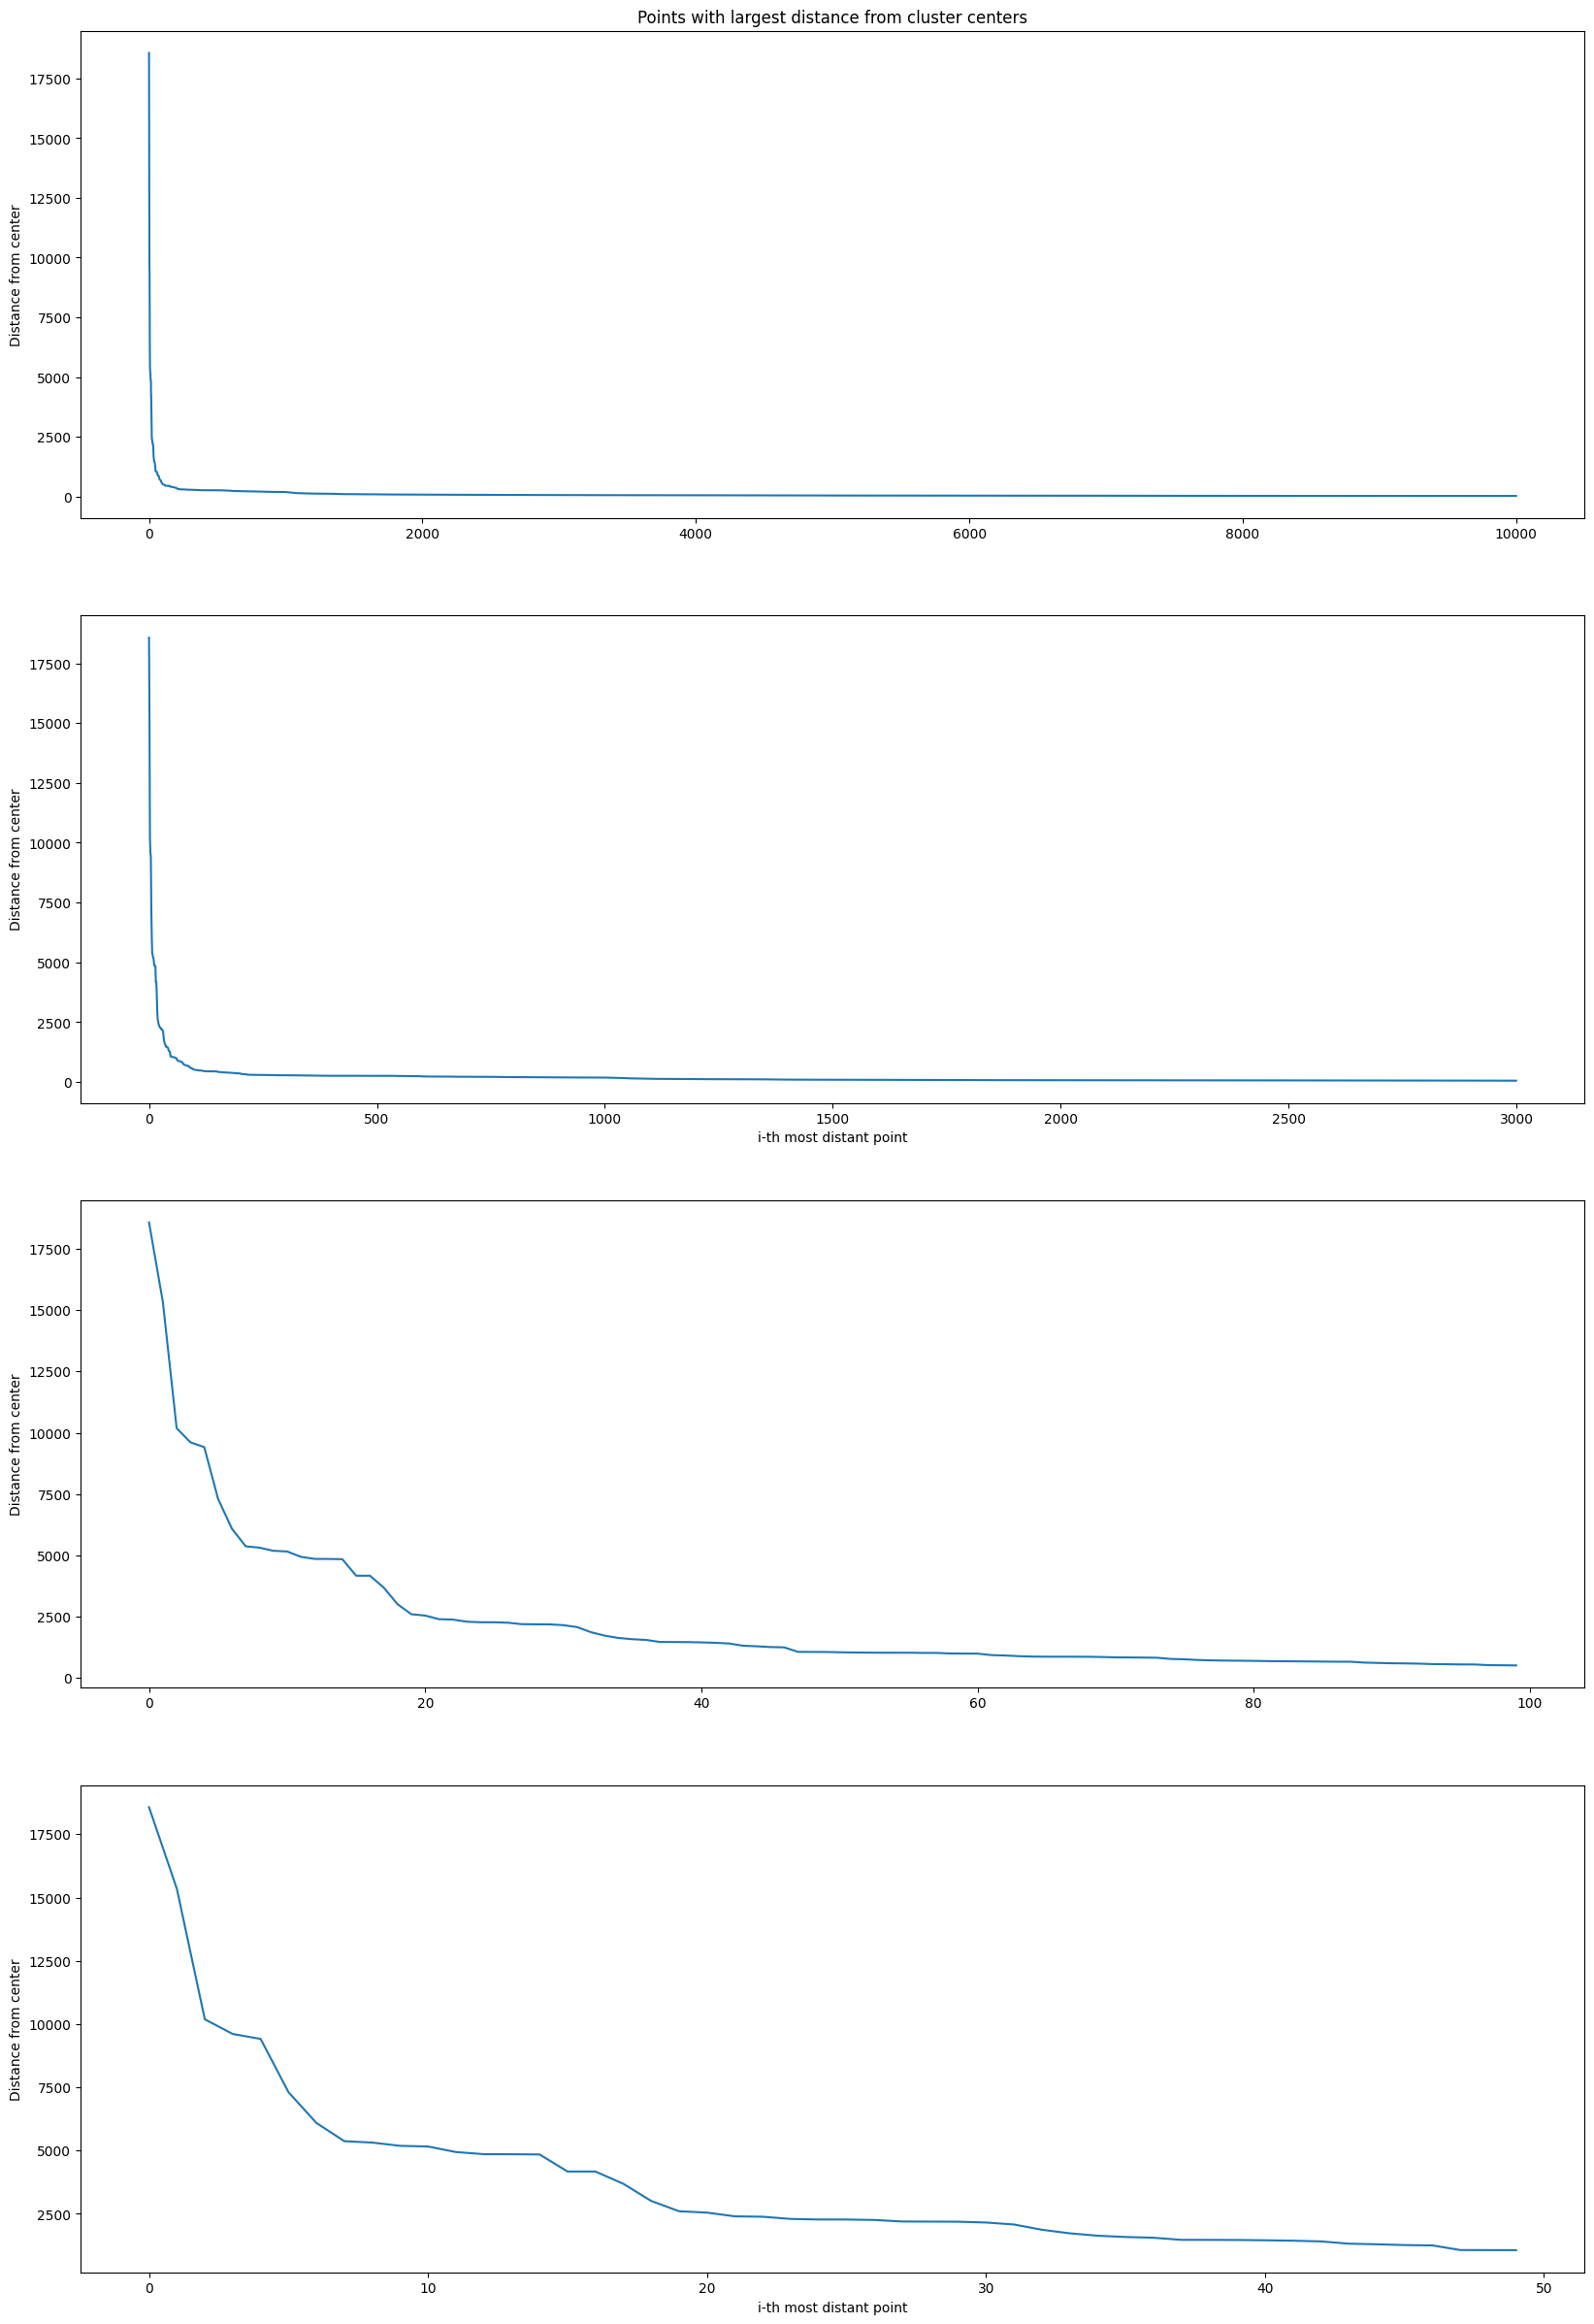

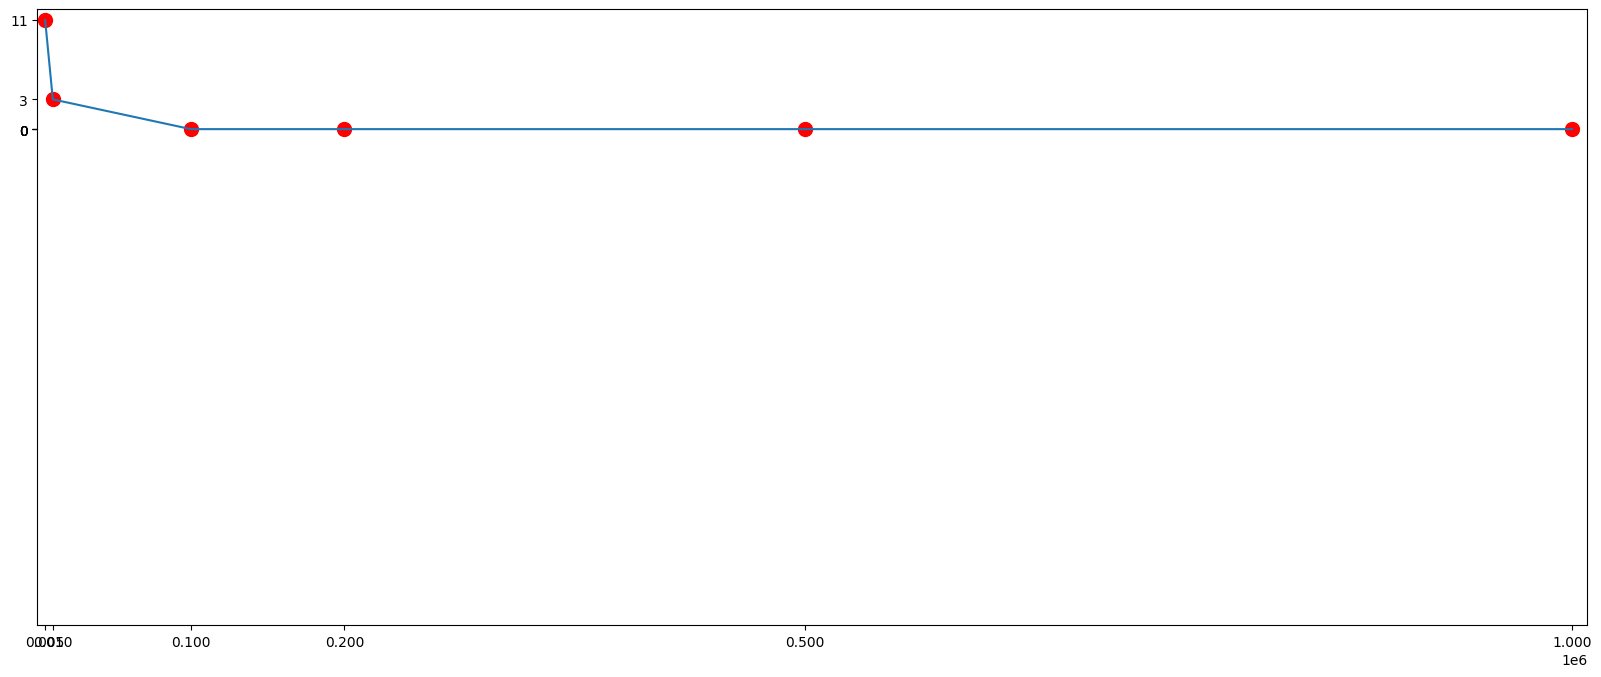

Threshold:    1000000	anomalous connections:     0
Threshold:     500000	anomalous connections:     0
Threshold:     200000	anomalous connections:     0
Threshold:     100000	anomalous connections:     0
Threshold:      10000	anomalous connections:     3
Threshold:       5000	anomalous connections:    11


In [35]:
# Get the indices of the sorted distances
sorted_idx = np.argsort(-distances)

# Select the top 10000 most distant points
top_points = distances[sorted_idx][:10000]

# Plotting the points with largest distance from cluster centers
plt.figure(figsize=(20,30))
plt.subplot(411)
plt.plot(top_points)
plt.title("Points with largest distance from cluster centers")
plt.ylabel("Distance from center")

# Repeat the plotting for different subsets
plt.subplot(412)
plt.plot(top_points[:3000])
plt.ylabel("Distance from center")
plt.xlabel("i-th most distant point")

plt.subplot(413)
plt.plot(top_points[:100])
plt.ylabel("Distance from center")

plt.subplot(414)
plt.plot(top_points[:50])
plt.ylabel("Distance from center")
plt.xlabel("i-th most distant point")
plt.show()

# Define thresholds and count the number of points above each threshold
thresholds = [1000000, 500000, 200000, 100000, 10000, 5000]
t_count = [np.sum(distances > threshold) for threshold in thresholds]

# Plot the thresholds vs number of points above the threshold
plt.figure(figsize=(20,8))
plt.scatter(thresholds, t_count, c="r", s=100)
plt.plot(thresholds, t_count)
plt.yticks(t_count)
plt.xticks(thresholds)
plt.ylim(-50, np.max(t_count)*1.1)
plt.xlim(0, np.max(thresholds)*1.01)
plt.show()

# Print the counts for each threshold
for threshold, count in zip(thresholds, t_count):
    print(f"Threshold: {threshold:10d}\tanomalous connections: {count:5d}")

**Your comments**
At very high thresholds (1,000,000 down to 100,000), no data points are considered anomalies. This suggests that all data points in your dataset are within a reasonable distance from their nearest centroids, indicating that these thresholds are set too high to be useful for anomaly detection in your dataset.

At a threshold of 10,000, you have 3 anomalous connections. This suggests that there are very few data points that are far enough from their centroids to be considered outliers. These could be true anomalies that are worth investigating for potential issues or interesting events.

At a lower threshold of 5,000, the number of anomalies detected increases to 11. This gives a larger pool of potential anomalies and may include more false positives, i.e., data points that are unusual but not necessarily problematic.

Choosing a threshold is about balance. Too high, and you miss detecting anomalies; too low, and you may get too many false positives. The 100th-farthest point distance could be a good starting point for setting a threshold, as it is likely to be distant enough to separate out true anomalies from normal variations in the data, without being so sensitive that it picks up too many data points.